# [IAPR][iapr]: Lab 1 ‒  Image segmentation


**Group ID:** 36

**Author 1 (sciper):** Ke Wang (326760)  
**Author 2 (sciper):** Jiaan Zhu (325421)   
**Author 3 (sciper):** Rémy Dornier (271174)   

**Release date:** 12.03.2021  
**Due date:** 26.03.2021 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1: Brain segmentation

Your goal: compute the size of the brain (without the skull) in pixels in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI) using:
* Region growing (5 pts)
* Contour detection (5 pts)
* Additional method of your choice (5 pts)

Each section should display the resulting segmenttion as well as the size in pixel of the detected region. Comment each method limitations and/or advantages.

### 1.1 Brain image visualization

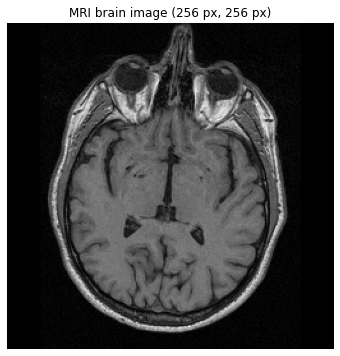

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing (5pts)

The implemented region growing algorithm starts with a given seed point that can be changed until its coordinates remain on the brain. Then, candidate pixels are only taken from front pixes' neighbors. Front pixels are pixels that are at the interface between the region and the background. If candidate pixels are suffisiantly similar to those in the region, then they are added to the region and become the new front pixels. The similarity criterion is based on the difference of intensity between the pixel intensity and the average intensity of the region. The growing stops when no more pixels can be added to the region. Because the image is a little bit noisy, a pre-processing step has been added. A mediane filter is used to remove the small noise. The radius of ineterest has been set to 1 because the image is quite small.

The region growing algorithm can correctly separate the regions that are homogeneous according to a criteria. This criteria can include many parameters at the same time (here, one is suffisiant). However, it is sensitive to noise (in general, need a pre-processing step to denoise the image). It also may suffer from a too local view of the problem. We try to decrease this issue by looking at the mean intensity of the region to have a more global view. The implemented way, using the front points concept, reduces the amount of pixels to see at each iteration.

The result is quite good. The dark intensities on brain boundaries introduce a small bias in the segmented brain (larger holes than in reality).

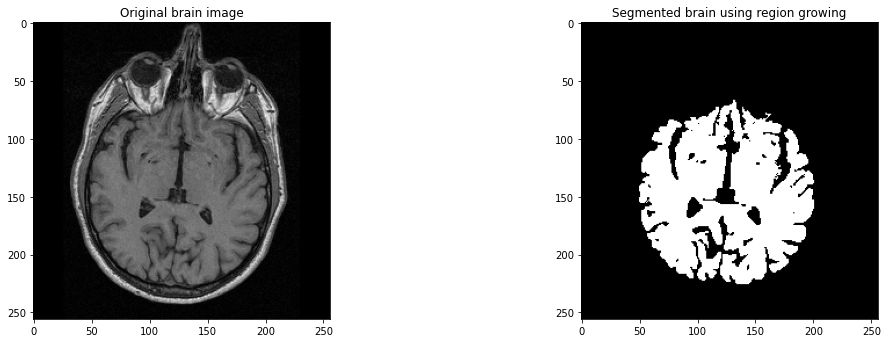

seed point : [150,148]
brain area using region growing : 15084.0 pix


In [3]:
import numpy as np
import cv2
import math
import skimage.filters


# define the seed point from which the growing begin
# it is possible to change its coordinates only if they remain in the brain
seed_point_x = 150
seed_point_y = 148

# preprocessing : do a median filtering to remove the noise
# median filter is used instead of a gaussian filter because better results have been achieved
brain_img = brain_im.copy()
radius = 1
brain_img = skimage.filters.median(brain_img, skimage.morphology.disk(radius))

# variables initialization
threshold = 0.1
in_region = 255
s_ngb = 9         # s_ngb = d*d. The 2D neighborhood should be a square with odd dimensions d 
s_ngb_sq = np.uint8(math.sqrt(s_ngb))
min_im = brain_img.min()
max_im = brain_img.max()

# front points coordinates array initialization
x_front = np.array([seed_point_x])
y_front = np.array([seed_point_y])

# full region pixels array initialization
region_list = np.array([brain_img[seed_point_x, seed_point_y]])

# binary image initialization
mask = np.zeros((im_h, im_w))
mask[seed_point_x, seed_point_y] = in_region

while x_front.size != 0:
    # get 2D coordinates of front pixels' neighbors
    X = [1 for i in range(s_ngb * len(x_front))]
    Y = [1 for i in range(s_ngb * len(y_front))]
    for i in range(0, s_ngb_sq):
        X[3 * i::s_ngb] = x_front[:] - 1
        X[3 * i + 1::s_ngb] = x_front[:]
        X[3 * i + 2::s_ngb] = x_front[:] + 1
        Y[3 * i::s_ngb] = y_front[:] + i - 1
        Y[3 * i + 1::s_ngb] = y_front[:] + i - 1
        Y[3 * i + 2::s_ngb] = y_front[:] + i - 1
 
    # convert the 2D coordinates into 1D coordinates
    Z = np.array(X) + im_w * np.array(Y)
    
    # remove identical pixels
    Z = np.unique(Z)
    
    # convert the 1D coordinates into 2D coordinates
    Y = np.uint8(Z / im_w)
    X = Z-(im_w * Y)
    
    # remove out-of-image points
    D = (X >= 0) * (Y >= 0) * (X < im_w) * (Y < im_h)
    X = X[np.array(D)]
    Y = Y[np.array(D)]
     
    # remove points that are already in the region
    P = mask[X,Y] != in_region
    X = X[np.array(P)]
    Y = Y[np.array(P)]
    
    # compute similarity criterion and remove non-similar pixels
    cost = abs(brain_img[X,Y] - (sum(region_list) / len(region_list))) / (max_im - min_im)
    V = cost < threshold
    X = X[np.array(V)]
    Y = Y[np.array(V)]
    
    # update front points, mask and pixels
    x_front = X
    y_front = Y
    mask[X,Y] = in_region
    region_list = np.concatenate((region_list, brain_img[X,Y]))

# output images
plt.figure(figsize=(18,12))
plt.subplot(2, 2, 1)
plt.imshow(brain_im, cmap ='gray')
plt.title('Original brain image')
plt.subplot(2, 2, 2)
plt.imshow(mask, cmap ='gray')
plt.title('Segmented brain using region growing')
plt.show()

# brain size
print('seed point : [{},{}]' .format(seed_point_x, seed_point_y))
print('brain area using region growing : {} pix' .format(sum(sum(mask)) / 255))

### 1.3 Contour detection (5pts)

The contour base-method used here is the canny edge detection

* Advantage:
 1. Canny edge detection is adaptable to various environments.
 2. Its parameters permit it to be customized to recognize the edges with different characteristics.
 3. It is a well defined method which offers a reliable detection.
 4. It is the most popular edge detection method because it meets the three criteria for edge detection and it is easy to use.
 

* Disadvantage:
 1. If the amount of smoothing required is important in the spatial domain it may be slow to compute.
 2. It gives a bias towards vertical and horizontal edges and does not give a good approximation of rotational symmetry.


A gaussian blurring is done to remove the noise. Then, the canny edge detector is applied, follwed by a morphological dilation to enhance edges. An already-implemented contour detector (from open cv) is used to list contours (make them as objects). Because the brain has a large shape, its perimeter (= contour) should be long. So, only the 3 largest contours are extracted. The second one correspond to the brain perimeter but the inner holes are considered as part of the brain. The third largest contour effectively correspond to these so-called holes. So, by subracting the holes area to the brain area, it gives the brain mask. An erosion operation on the holes shape is done before subtraction to better fit the reality. This operation is not done on the brain shape because it deforms it too much.  
The size of structuring element, as well as double threshold for canny detection, has been tuned to have the better brain contours.

The final brain mask, even if it has a very similar area compared to the region growing result, is smoother, simpler. Small details are not resolved but the global shape is recovered.  
Here, because we do not look at pixel values, the darker boundary intensities are fully part of the brain, whereas it can be an issue when thresholding or region growing.  
Every small holes inside the brain are not detected because their contour is very small and therefore considered as noise.

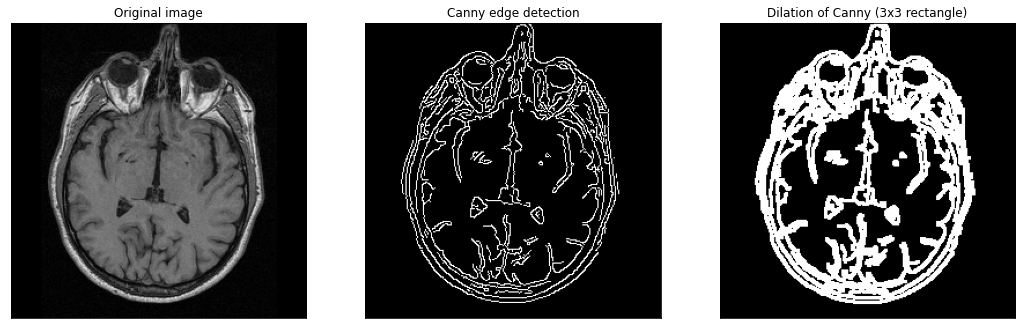

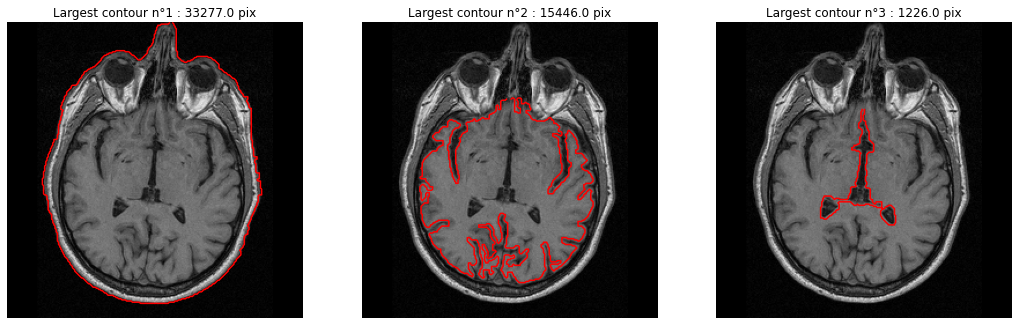

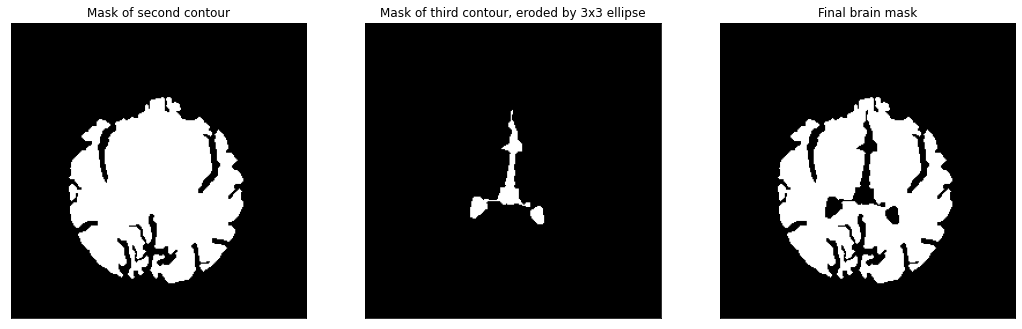

Brain area using contour detection : 15050 pix


In [4]:
import heapq

brain_img = brain_im.copy()

# remove noise
img_blur = cv2.GaussianBlur(brain_img, (3,3), 0)

# convolute with proper kernels
canny = cv2.Canny(img_blur, 60, 120)
b = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3));
dilate = cv2.dilate(canny, b, borderType = cv2.BORDER_REFLECT);

# find contours
contours, heirarchy = cv2.findContours(dilate, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# get the three larger contours
area_list = []
for i in range(len(contours)):
    area = cv2.contourArea(contours[i])
    area_list.append(area)
area_descent = map(area_list.index, heapq.nlargest(3, area_list)) 
area_descent = list(area_descent)
area_max = heapq.nlargest(3, area_list)

# plot images
plt.figure(figsize = (18,12))
plt.subplot(1,3,1),plt.imshow(brain_im,cmap = 'gray')
plt.title('Original image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,2),plt.imshow(canny,cmap = 'gray')
plt.title('Canny edge detection'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,3),plt.imshow(dilate,cmap = 'gray')
plt.title('Dilation of Canny (3x3 rectangle)'), plt.xticks([]), plt.yticks([])
plt.show()

# plot contours on the original brain image
plt.figure(figsize = (18,12))
for i,n in enumerate(area_descent):
    plt.subplot(1,3,i + 1)
    plt.imshow(brain_im, cmap = 'gray')
    plt.plot(contours[n].reshape(-1,2)[:,0], contours[n].reshape(-1,2)[:,1], color = 'red')
    plt.axis('off')
    plt.title('Largest contour n°{} : {} pix' .format(i + 1, area_max[i]))
plt.show()

# empty image
mask_inside1 = np.zeros(brain_img.shape, np.uint8)
mask_inside2 = np.zeros(brain_img.shape, np.uint8)

#draw the segmented brain
cv2.drawContours(mask_inside1, [contours[area_descent[1]]], 0, 255, -1)
cv2.drawContours(mask_inside2, [contours[area_descent[2]]], 0, 255, -1)

# erode the second mask to get a more realistic shape
b = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3));
mask_inside2 = cv2.erode(mask_inside2, b, borderType = cv2.BORDER_REFLECT);

# subtract the second mask to the first mask to find the final brain mask
mask_inside = mask_inside1 - mask_inside2
pixel_point = cv2.findNonZero(mask_inside)

# plot masks
plt.figure(figsize = (18,12))
plt.subplot(1,3,1),plt.imshow(mask_inside1,cmap = 'gray')
plt.title('Mask of second contour'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,2),plt.imshow(mask_inside2,cmap = 'gray')
plt.title('Mask of third contour, eroded by 3x3 ellipse'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,3),plt.imshow(mask_inside,cmap = 'gray')
plt.title('Final brain mask'), plt.xticks([]), plt.yticks([])
plt.show()

# brain area
print('Brain area using contour detection : {} pix' .format(pixel_point.shape[0]))

### 1.4 Additional method (5pts)

The implemented method is a thresholding method. 

Based on two different thresholds, it keeps every pixel between t_low and t_high after a gaussian blurring and media filter to remove small noise.
Thresholds have been set according to the image histogram, where we can see a peak around 75-80.
Then, a connected component analysis is performed to keep only the largest region in the image (the one
corresponding to the brain).

This method is more sensitive to parameters than the region growing one.
The sigma of the gaussian blurring, as well as the radius of the median filter, has te be 
adjusted according to the level of noise and to the size of the image. 
Thresholds really depend on what we want to segment on the image and will necessarly be not 
the same for another image.

However, the result is not so bad, even quit good. There are some little noisy dots but the overall segmentation is 
quite homogeneous and coherent with the two previous segmentations. 
The final brain mask results from a tradeoff between noise removal and brain shape.

brain area using thresholding : 15023 pix


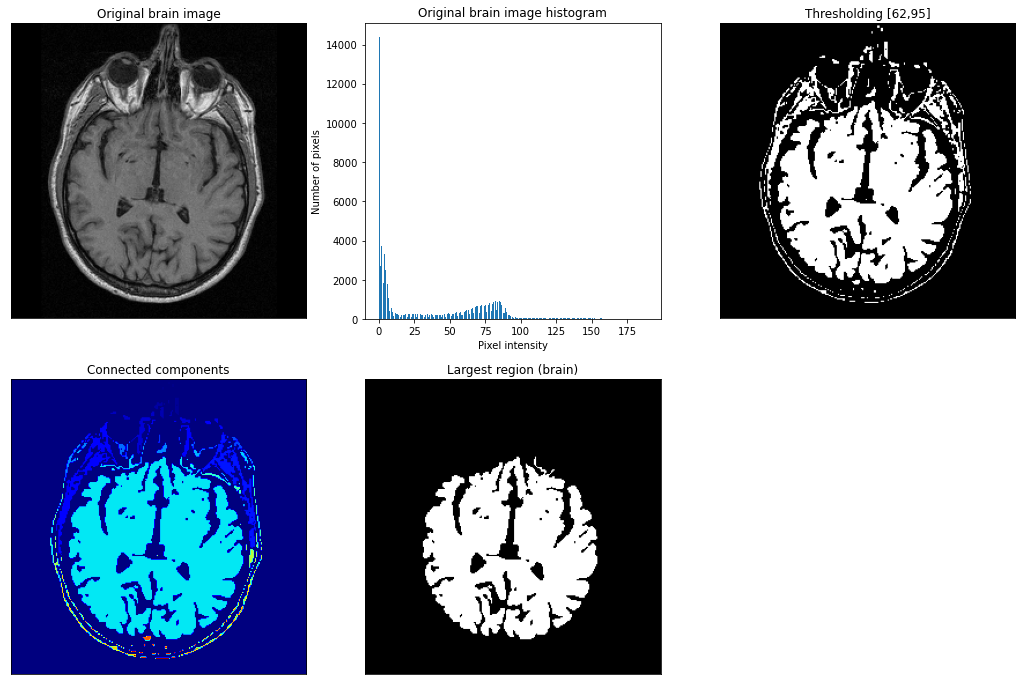

In [5]:
import numpy as np
import cv2
from skimage import measure, color

brain_img2 = brain_im.copy()

# plot original image and its histogram
plt.figure(figsize = (18,12))
plt.subplot(2,3,1),plt.imshow(brain_img2,cmap = 'gray')
plt.title('Original brain image'), plt.xticks([]), plt.yticks([])
plt.subplot(2, 3, 2)
plt.hist(brain_img2.ravel(), bins=256)
plt.xlabel('Pixel intensity')
plt.ylabel('Number of pixels')
plt.title('Original brain image histogram')

# Preprocessing : Gaussian blurring and median filter 
radius = 1
brain_img2 = skimage.filters.gaussian(brain_img2, sigma = 0.5) * 255
brain_img2 = skimage.filters.median(brain_img2, skimage.morphology.disk(radius))

# Image thresholding
t_low = 62
t_high = 95
brain_img2[brain_img2 > t_high] = 0
brain_img2[brain_img2 < t_low] = 0 
brain_img2[brain_img2 > 0] = 255 

# plot the thresholding image
plt.subplot(2,3,3),plt.imshow(brain_img2,cmap = 'gray')
plt.title('Thresholding [{},{}]' .format(t_low,t_high)), plt.xticks([]), plt.yticks([])

# Label the white region to get properties on that regions.
labels = measure.label(brain_img2)
stats = measure.regionprops(labels)

# plot labeled regions
plt.subplot(2,3,4),plt.imshow(labels,cmap = 'jet')
plt.title('Connected components'), plt.xticks([]), plt.yticks([])

# get the largest region in the image 
t_region_area = 0
for region in stats:
    if region.area > t_region_area:
        brain_region = region.label
        t_region_area = region.area

# drawing of the brain
brain_mask = np.zeros(brain_img2.shape, np.uint8)
brain_mask[labels == brain_region] = 255
pixel_point = cv2.findNonZero(brain_mask)

# plot final brain mask
plt.subplot(2,3,5),plt.imshow(brain_mask,cmap = 'gray')
plt.title('Largest region (brain)'), plt.xticks([]), plt.yticks([])

# brain size
print('brain area using thresholding : {} pix' .format(pixel_point.shape[0]))

---
## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color (5pts).
2. Compute the total area (in pixels) of each color (5pts).

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

### 2.1 Visualization

In [6]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


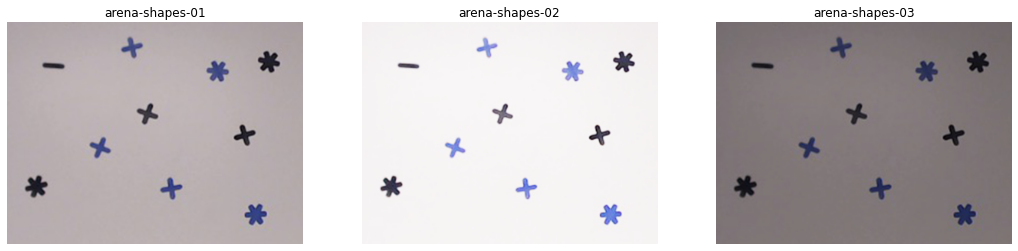

In [7]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(18, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color (5 pts)

In [8]:
# Performs a thresholding operation on the image with two thresholds.
# Everything inside [T1,T2] is set to 255. Otherwise, it is set to 0.
def threshold_image(imgo, T1, T2):
    img = imgo.copy()
    
    # thresholding
    img[img > T1] = 0
    img[img < T2] = 0
    img[img <= T1] = 255

    # removing noise
    img_bin = np.uint8(img)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (8,8))
    img_bin = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernel)
    
    return img_bin

In order to get rid of the different exposure, an RGB to HSV transformation is performed.  
On the HSV image representation, the brightness is normalized and the other channels are also normalized according to brightness.  
Finally, after normalization, the inverse transformation is performed to get back to the RGB representation.

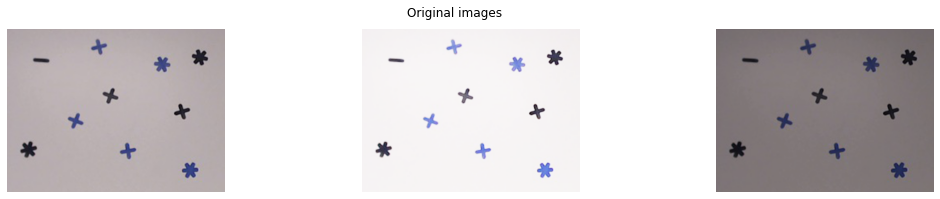

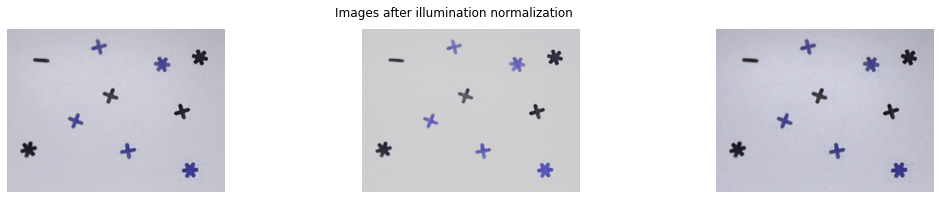

In [9]:
from skimage import exposure
from skimage import data, exposure, img_as_float

# show original images
plt.figure(figsize=(18,3))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.suptitle('Original images')
plt.show()

# convert image to hsb
images_hsb = np.zeros(np.shape(images))
for i in range(3):
    images_hsb[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2HSV)

# brighness normalization
images_norm_hsb = images_hsb
for i in range(3):
    images_norm_hsb[i][:,:,0] = images_hsb[i][:,:,0] / 179
    images_norm_hsb[i][:,:,1] = images_hsb[i][:,:,1] / 255
    # normalize the brightness of the image
    images_norm_hsb[i][:,:,2] = (images_hsb[i][:,:,2] - images_hsb[i][:,:,2].min())/(images_hsb[i][:,:,2].max() - images_hsb[i][:,:,2].min())

# set the brighness of each image to the same
images_norm_hsb[1][:,:,2] *= (images_hsb[0][:,:,2].mean()/images_hsb[1][:,:,2].mean())
images_norm_hsb[2][:,:,2] *= (images_hsb[0][:,:,2].mean()/images_hsb[2][:,:,2].mean())

# convert back to grb
images_norm = np.zeros(np.shape(images))
for i in range(3):
    images_norm[i] = cv2.cvtColor(images_norm_hsb[i].astype(np.float32), cv2.COLOR_HSV2BGR)
images_norm = images_norm.astype(np.float32)
images_norm[images_norm>1] = 1

# plot the images after illumination normalization
plt.figure(figsize=(18,3))
plt.suptitle('Images after illumination normalization')
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(images_norm[i])
    plt.axis('off')
plt.show()

After brightness normalization, the segmentation can be done.  

RGB images contain black object (same values for each channel) and blue objects (larger value in the blue channel than in the red or grenn one). So, the blue channel is extracted from RGB image. Then, to remove the effect of different illumination, a background subtraction is done by subtracting to the blue channel its mean value.

Now the intensity values are centered around 0, thresholds, followed by morphological opening, are applied to segment the objects. Putting the values around 0 was initilly used to have the same threshold for each image.  
However, this approach worked but the size of the objects was no the same on each image. That's why we decided to put different thresholds for each image, to get a similar color area for each image. Note that different thresholds are also applied according to the color of the object. 

<Figure size 432x288 with 0 Axes>

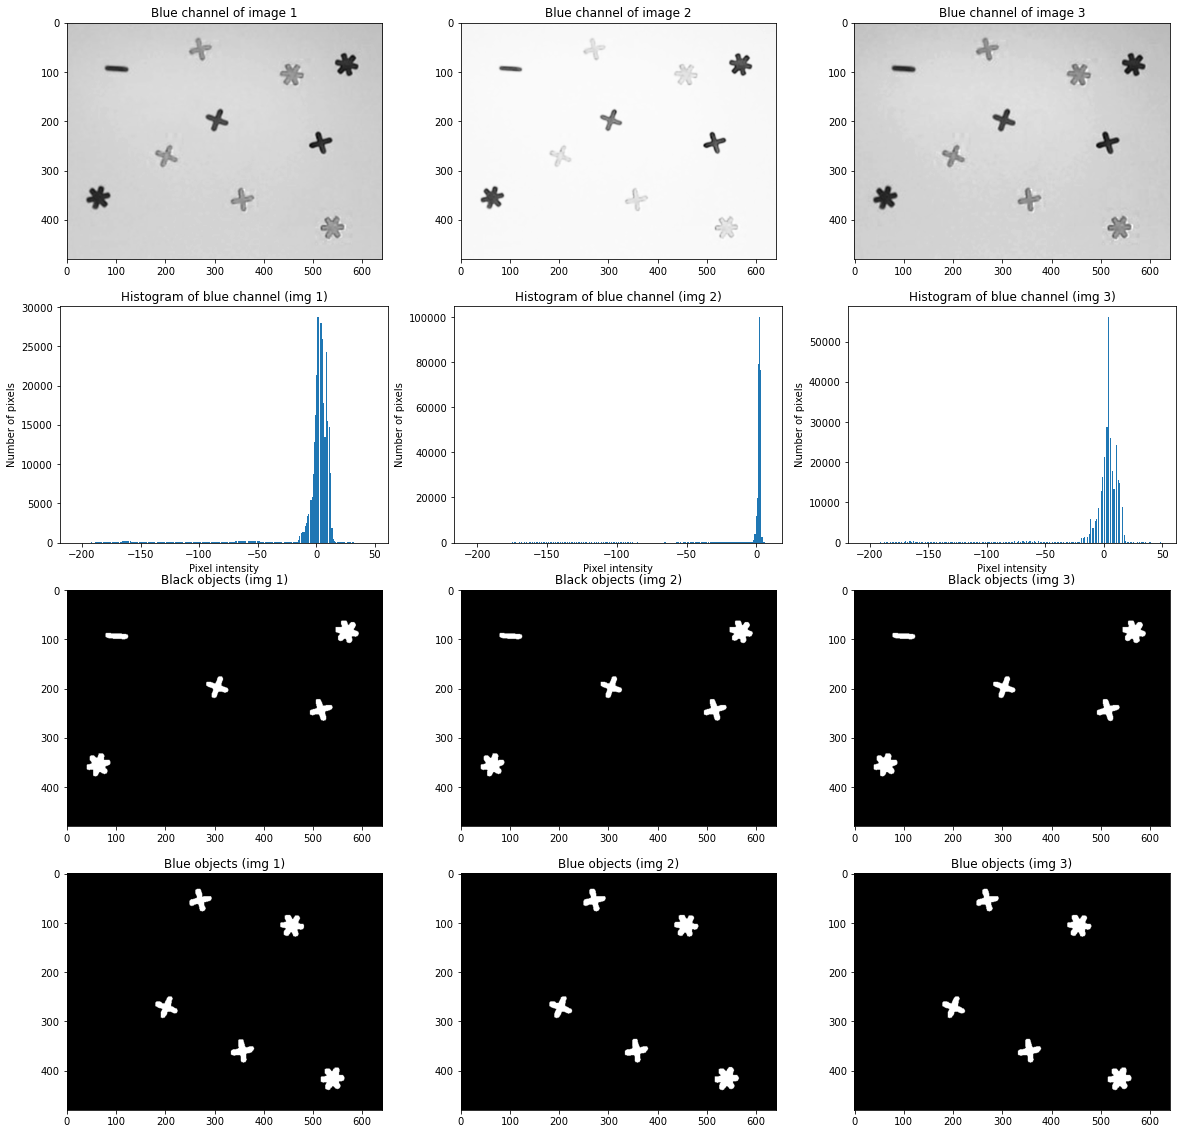

In [10]:
# Add your implementation and discussion
import skimage.filters
from skimage import measure, color

# initialize plots
nb_img = images_norm.shape[0]
plt.figure(1)
fig, axes = plt.subplots(1, nb_img + 1)
fig.set_size_inches(20, 20)

# thresholds for blue/black objects
T_sup_black = [-65, -25, -70]
T_inf_blue = [-135, -105, -135]
T_sup_blue = [-20, -2, -25]

for i in range(0, nb_img):
    # get the different channels of the image
    r,g,b = cv2.split(images_norm[i])
    img = np.float32(b) * 255
    
    # remove the mean of the image (to reduce the DC component of the image)
    img_back_sub = img - img.mean()
    
    # plot the resulting blue channel and its histogram
    plt.subplot(nb_img + 1, nb_img, i + 1)
    plt.imshow(img_back_sub, cmap = 'gray')
    plt.title('Blue channel of image {}' .format(i + 1))
    plt.subplot(nb_img + 1, nb_img, i + 1 + nb_img)
    plt.hist(img_back_sub.ravel(), bins = 256)
    plt.xlabel('Pixel intensity')
    plt.ylabel('Number of pixels')
    plt.title('Histogram of blue channel (img {})' .format(i + 1))
    
    # threshold black objects
    T_inf = img_back_sub.min()
    img_bin_black = threshold_image(img_back_sub, T_sup_black[i], T_inf)
                             
    plt.subplot(nb_img + 1, nb_img, i + 1 + (nb_img * 2))
    plt.title('Black objects (img {})'  .format(i + 1))
    plt.imshow(img_bin_black, cmap = 'gray')
    
    # threshold blue objects
    img_bin_blue = threshold_image(img_back_sub, T_sup_blue[i], T_inf_blue[i])

    plt.subplot(nb_img + 1, nb_img, i + 1 + nb_img * 3)
    plt.imshow(img_bin_blue, cmap = 'gray')
    plt.title('Blue objects (img {})'  .format(i + 1))
    
    # save thresholded images
    if i == 0:
        blue_stack = img_bin_blue
        black_stack = img_bin_black
    else:
        blue_stack = np.dstack((blue_stack, img_bin_blue))
        black_stack = np.dstack((black_stack, img_bin_black))


Based on binary images, a connected component analysis is done to find out the number of regions
on each image.  
Since there is one binary image for blue objects, and another one for black
objects, the number or each kind of object on each image can be computed.

In [11]:
# Compute the number of black/blue object for each image

for i in range(0, blue_stack.shape[2]):
    # label binary images
    blue_labels = measure.label(blue_stack[:,:,i])
    black_labels = measure.label(black_stack[:,:,i])
    
    # get properties for each labeled region 
    blue_stats = measure.regionprops(blue_labels)
    black_stats = measure.regionprops(black_labels)
    
    print('Number of blue object in image {} : {} ' .format(i + 1, len(blue_stats)))
    print('Number of black object in image {} : {} ' .format(i + 1, len(black_stats)))

Number of blue object in image 1 : 5 
Number of black object in image 1 : 5 
Number of blue object in image 2 : 5 
Number of black object in image 2 : 5 
Number of blue object in image 3 : 5 
Number of black object in image 3 : 5 


Based on previous results, a connected components analysis is done on each of the three binary
images The area of blue and black objects can therefore be computed.  
Black objects are composed of 2 stars and 2.5 crosses whereas blue objects are composed of 2 stars and 3 crosses. This explains the difference of total area between colors in the same image.

### 2.3 Total area (in pixels) of each color (5 pts)

In [12]:
# Add your implementation and discussion

for i in range(0, blue_stack.shape[2]):
    # label binary images
    blue_labels = measure.label(blue_stack[:,:,i])
    black_labels = measure.label(black_stack[:,:,i])
    
     # get properties for each labeled region 
    blue_stats = measure.regionprops(blue_labels)
    black_stats = measure.regionprops(black_labels)
    
    # compute the total area per color
    blue_area = 0
    black_area = 0
    for blue_obj in blue_stats:
        blue_area = blue_area + blue_obj.area
    
    for black_obj in black_stats:
        black_area = black_area + black_obj.area
        
    print('Area (in pix) of blue object in image {} : {} ' .format(i + 1, blue_area))
    print('Area (in pix) of black object in image {} : {} ' .format(i + 1, black_area))

Area (in pix) of blue object in image 1 : 5506 
Area (in pix) of black object in image 1 : 4936 
Area (in pix) of blue object in image 2 : 5645 
Area (in pix) of black object in image 2 : 4877 
Area (in pix) of blue object in image 3 : 5560 
Area (in pix) of black object in image 3 : 4974 
